In [1]:
import numpy as np
import pandas as pd
from aerobot.io import RESULTS_PATH, ASSET_PATH, FEATURE_TYPES
from aerobot.dataset import dataset_load_all
from aerobot.models import GeneralClassifier
import os

In [2]:
RESULTS_PATH = os.path.join(RESULTS_PATH, 'earth_microbiome')

## Running model on EMB data

EMB data is stored on HPC under `/central/groups/fischergroup/goldford/earth_microbiome/proteins`. The data file has a column for each amino acid trimer (there are over 9000). I think I will need to filter the features to match the features the model was trained on, as several columns are dropped when loading the raw feature data into a `dataset`.

In [8]:
# First step is to train a nonlinear model on the training data. 
! python ../scripts/run.py 'nonlinear' --feature-type 'aa_3mer' --save-model 1 --n-epochs 500 --save-model-path 'aa_3mer_nonlinear_model.joblib'

Training NonlinearClassifier...:  26%|██      | 130/500 [22:56<36:56,  5.99s/it]

In [4]:
# Turns out loading the whole DataFrame crashes my laptop, so running on HPC.

# Load in aa_3mer features for Earth Microbiome Project samples. First column seems to be 'Unnamed: 0'.
emb_data = pd.read_csv(os.path.join(RESULTS_PATH, 'emb_aa_3mer.csv'), index_col=0, nrows=2)
print('Number of features in EMB data:', len(emb_data.columns))

Number of features in EMB data: 9702


In [5]:
emb_data.columns.to_numpy()

array(['NIK', 'IKV', 'KVG', ..., 'YX*', 'MX*', 'HX*'], dtype=object)

In [6]:
# Now need to get information about the aa_3mers retained in the training data. 
dataset = dataset_load_all(feature_type='aa_3mer', to_numpy=False)
aa_3mers = dataset['features'].columns
print('Number of features in training data:', len(aa_3mers))
print('Number of features in both training and EMB data:', len(set(aa_3mers).intersection(set(emb_data.columns))))

Number of features in training data: 8675
Number of features in both training and EMB data: 8675


## Cleaning data

In [7]:
# Load the Earth microbiome project analysis and metadata
emb_metadata_df = pd.read_csv(os.path.join(RESULTS_PATH, 'emb_metadata.tsv'), sep='\t', index_col=0)
EMP_res_df = pd.read_csv('../../results/aa3mer.aerotype.EarthMicrobiome.csv', index_col=0)
EMP_merged = EMP_res_df.join(EMP_meta_df, how='outer')


FileNotFoundError: [Errno 2] No such file or directory: '/home/prichter/Documents/aerobot/aerobot/../results/earth_microbiome/emb_metadata.tsv'

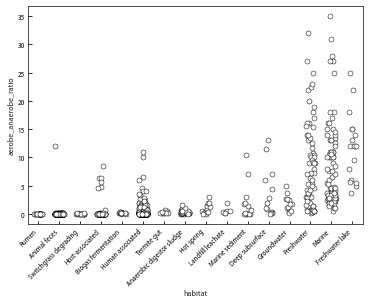

In [ ]:
# Load the mean aerobe/anaerobe predictions for each habitat
mean_EMP_pcts_df = pd.read_csv('../../results/EMP_merged_filtered_mean_fracs_by_habitat.csv', index_col=0)

EMP_fracs_df = pd.read_csv('../../results/EMP_merged_filtered_fracs_by_sample.csv', index_col=0)

EMP_fracs_df.head()
mask = mean_EMP_pcts_df.total > 250
sorted_habitats = mean_EMP_pcts_df[mask].sort_values('f_Aerobe', ascending=True).index.values
mask2 = EMP_fracs_df.habitat.isin(sorted_habitats)

# Ideally I'd like to plot fold differences in aerobe/anaerobe ratios on a log scale
# however there are many samples where the ratio is 0 or infinity, so I can't do that.
plt.figure()
#plt.yscale('log')
sns.stripplot(data=EMP_fracs_df[mask2], x='habitat', y='aerobe_anaerobe_ratio',
              jitter=0.2, order=sorted_habitats, color='white', edgecolor='k', linewidth=0.5)

plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Load the black sea metadata
black_sea_metadata = pd.read_csv('../../results/black-sea/meta_data.csv', index_col=0)
black_sea_metadata['depth_m'] = black_sea_metadata['Depth'].str.strip('m').astype(float)

# Chemical measurements are from Sollai et al. 2019 Geobiology. In their figure 1
# it's clear these are in uM units despite what it says in our metadata file, which
# was downloaded from the SRA at this link:
# https://www.ncbi.nlm.nih.gov/Traces/study/?query_key=3&WebEnv=MCID_6582027b68a595196d9af8e7&o=acc_s%3Aa
# uM units make sense as the Henry's law equilibrium of O2 in seawater is ~200 uM.
black_sea_metadata['o2_uM'] = black_sea_metadata.diss_oxygen.str.strip('mmol / kg').astype(float)
black_sea_metadata['h2s_uM'] = black_sea_metadata['hydrogen_sulfide'].str.strip('mM').astype(float)
black_sea_metadata.sort_values('depth_m', inplace=True)

In [ ]:
# Load the black sea MAG inference results
black_sea_aerotypes = pd.read_csv('../../results/black-sea/black_sea_aerotypes.aa3merModel.csv', index_col=0)
black_sea_MAG_fractions = pd.read_csv('../../results/black-sea/blackSea.MAGfraction.04Feb2023.csv', index_col=0).drop('*')

black_sea_MAG_fractions['aerotype'] = black_sea_aerotypes.loc[black_sea_MAG_fractions.index]
O2_utilzation_fracs = black_sea_MAG_fractions.groupby('aerotype').sum().T
O2_utilization_pcts = O2_utilzation_fracs*100

# Check the totals
totals = O2_utilization_pcts.sum(axis=1)
assert (totals - 100).abs().max() < 1e-6

O2_utilization_pcts['depth_m'] = black_sea_metadata.loc[O2_utilization_pcts.index].depth_m
O2_utilization_pcts.sort_values('depth_m', inplace=True)
O2_utilization_pcts.head()

aerotype,Aerobe,Anaerobe,Facultative,depth_m
SRR12347146,91.576737,1.418828,7.004435,50.0
SRR12347145,94.658995,4.980436,0.360570,70.0
SRR12347139,95.031219,4.731364,0.237417,80.0
SRR12347138,91.762149,7.937447,0.300404,85.0
SRR12347137,89.494802,10.136071,0.369127,90.0


In [ ]:
# Perform regression analysis of O2/H2S ratio vs. aerobe/anaerobe ratio
ox_sulfide_ratio = black_sea_metadata.o2_uM/black_sea_metadata.h2s_uM
aerobe_anaerobe_ratio = O2_utilization_pcts.Aerobe/O2_utilization_pcts.Anaerobe

# linear regression of the log-log data
log_ox_sulfide_ratio = np.log10(ox_sulfide_ratio)
log_aerobe_anaerobe_ratio = np.log10(aerobe_anaerobe_ratio)

reg_res = linregress(log_aerobe_anaerobe_ratio, log_ox_sulfide_ratio)
print(reg_res)
xs = np.logspace(-0.8, 2.1, 100)
pred_ys = reg_res.intercept + reg_res.slope*np.log10(xs)

LinregressResult(slope=2.3302367776414075, intercept=-1.6431460955366983, rvalue=0.9418088107235977, pvalue=1.599384514180643e-07, stderr=0.2306733790166578, intercept_stderr=0.18563170021693645)


habitat
Rumen                         606.0
Animal feces                 6639.0
Switchgrass degrading         494.0
Biogas fermentation           506.0
Termite gut                   319.0
Sediment                      245.0
Anaerobic digestor sludge    1656.0
Human associated             4983.0
Hot spring                    614.0
Landfill leachate             269.0
Marine sediment               320.0
Hot spring sediment           243.0
Deep subsurface               357.0
Groundwater                   419.0
Freshwater                   2814.0
Marine                       2633.0
Freshwater lake               416.0
Salt marsh                    247.0
Name: total, dtype: float64


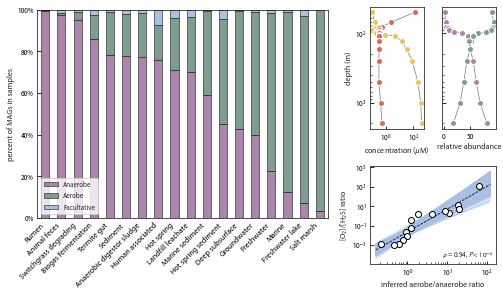

In [ ]:
fig = plt.figure(figsize=(6.875, 4), constrained_layout=True)
subfigs = fig.subfigures(nrows=1, ncols=2, wspace=0.02,
                         width_ratios=[2,1])

leftAx = subfigs[0].subplots(nrows=1, ncols=1)
rightAxs = subfigs[1].subplots(nrows=2, ncols=2, sharey='row',
                               gridspec_kw={'height_ratios': [1.25, 1]})

plt.sca(leftAx)
cols = 'habitat,pct_Anaerobe,pct_Aerobe,pct_Facultative'.split(',')
tmp = mean_EMP_pcts_df.reset_index()
mask = np.logical_and(tmp.total > 240,
                      np.logical_not(tmp.habitat.isin(['Host-associated'])))

sorted = tmp[cols][mask].set_index('habitat').sort_values('pct_Anaerobe', ascending=False)
sorted.plot(kind='bar', stacked=True, color=default_pal[:3], ax=leftAx, legend=False,
            edgecolor='k', linewidth=0.5)

# Printing the total number of MAGs per sample to verify it exceeds 250
totals = mean_EMP_pcts_df.loc[sorted.index].total
print(totals)

plt.legend('Anaerobe,Aerobe,Facultative'.split(','), loc=3)
plt.ylabel('percent of MAGs in samples')
plt.xlabel('')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.ylim(0, 100.1)
leftAx.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.sca(rightAxs[0, 0])
# Invert only the first -- also inverts the second since they share a y-axis.
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yscale('log')
plt.plot(black_sea_metadata.h2s_uM, black_sea_metadata.depth_m, marker='o', ls='-', lw=0.75,
         color='grey', markerfacecolor=colors['yellow'], markeredgecolor='w', label='H$_2$S')
plt.plot(black_sea_metadata.o2_uM, black_sea_metadata.depth_m, marker='o', ls='-', lw=0.75,
         color='grey', markerfacecolor=colors['red'], markeredgecolor='w', label='O$_2$')
plt.xlabel('concentration ($\mu$M)')
plt.ylabel('depth (m)')

plt.sca(rightAxs[0, 1])
plt.yscale('log')
for i, col in enumerate('Anaerobe,Aerobe'.split(',')):
    plt.plot(O2_utilization_pcts[col], O2_utilization_pcts.depth_m, marker='o', ls='-', lw=0.75,
         color='grey', markerfacecolor=default_pal[i], markeredgecolor='w', label=col)
#plt.ylabel('Depth (m)')
plt.xlabel('relative abundance')

# Make a big axis to hold the correlation plot
gs = rightAxs[1, 0].get_gridspec()
# remove the underlying axes
for ax in rightAxs[1, :]:
    ax.remove()    
axbig = subfigs[1].add_subplot(gs[1, :])

plt.sca(axbig)
plt.loglog(aerobe_anaerobe_ratio, ox_sulfide_ratio, marker='o', ls='', color='grey', markerfacecolor='w', markeredgecolor='k')

plt.plot(xs, 10**pred_ys, color='k', ls='--', lw=0.75, zorder=-1)
# bootstrap a confidence interval plot manually because
# seaborns regplot doesn't handle log scale...
for _ in range(1000):
    slope = np.random.normal(reg_res.slope, reg_res.stderr)
    intercept = np.random.normal(reg_res.intercept, reg_res.intercept_stderr)
    pred_ys = intercept + slope*np.log10(xs)
    plt.plot(xs, 10**pred_ys, color=colors['light_blue'], ls='-', lw=0.5, alpha=0.8,
             zorder=-10)

plt.xlabel('inferred aerobe/anaerobe ratio')
plt.ylabel('[O$_2$]/[H$_2$S] ratio')
plt.text(0.98, 0.03, '$\\rho$ = {0:.2f}, $P < 10^{{-6}}$'.format(reg_res.rvalue, reg_res.pvalue),
         fontsize=7, transform=plt.gca().transAxes, ha='right', va='bottom')


plt.savefig('../../results/Fig2.png', dpi=300, facecolor='w')